# Seasonal Phasing Analysis

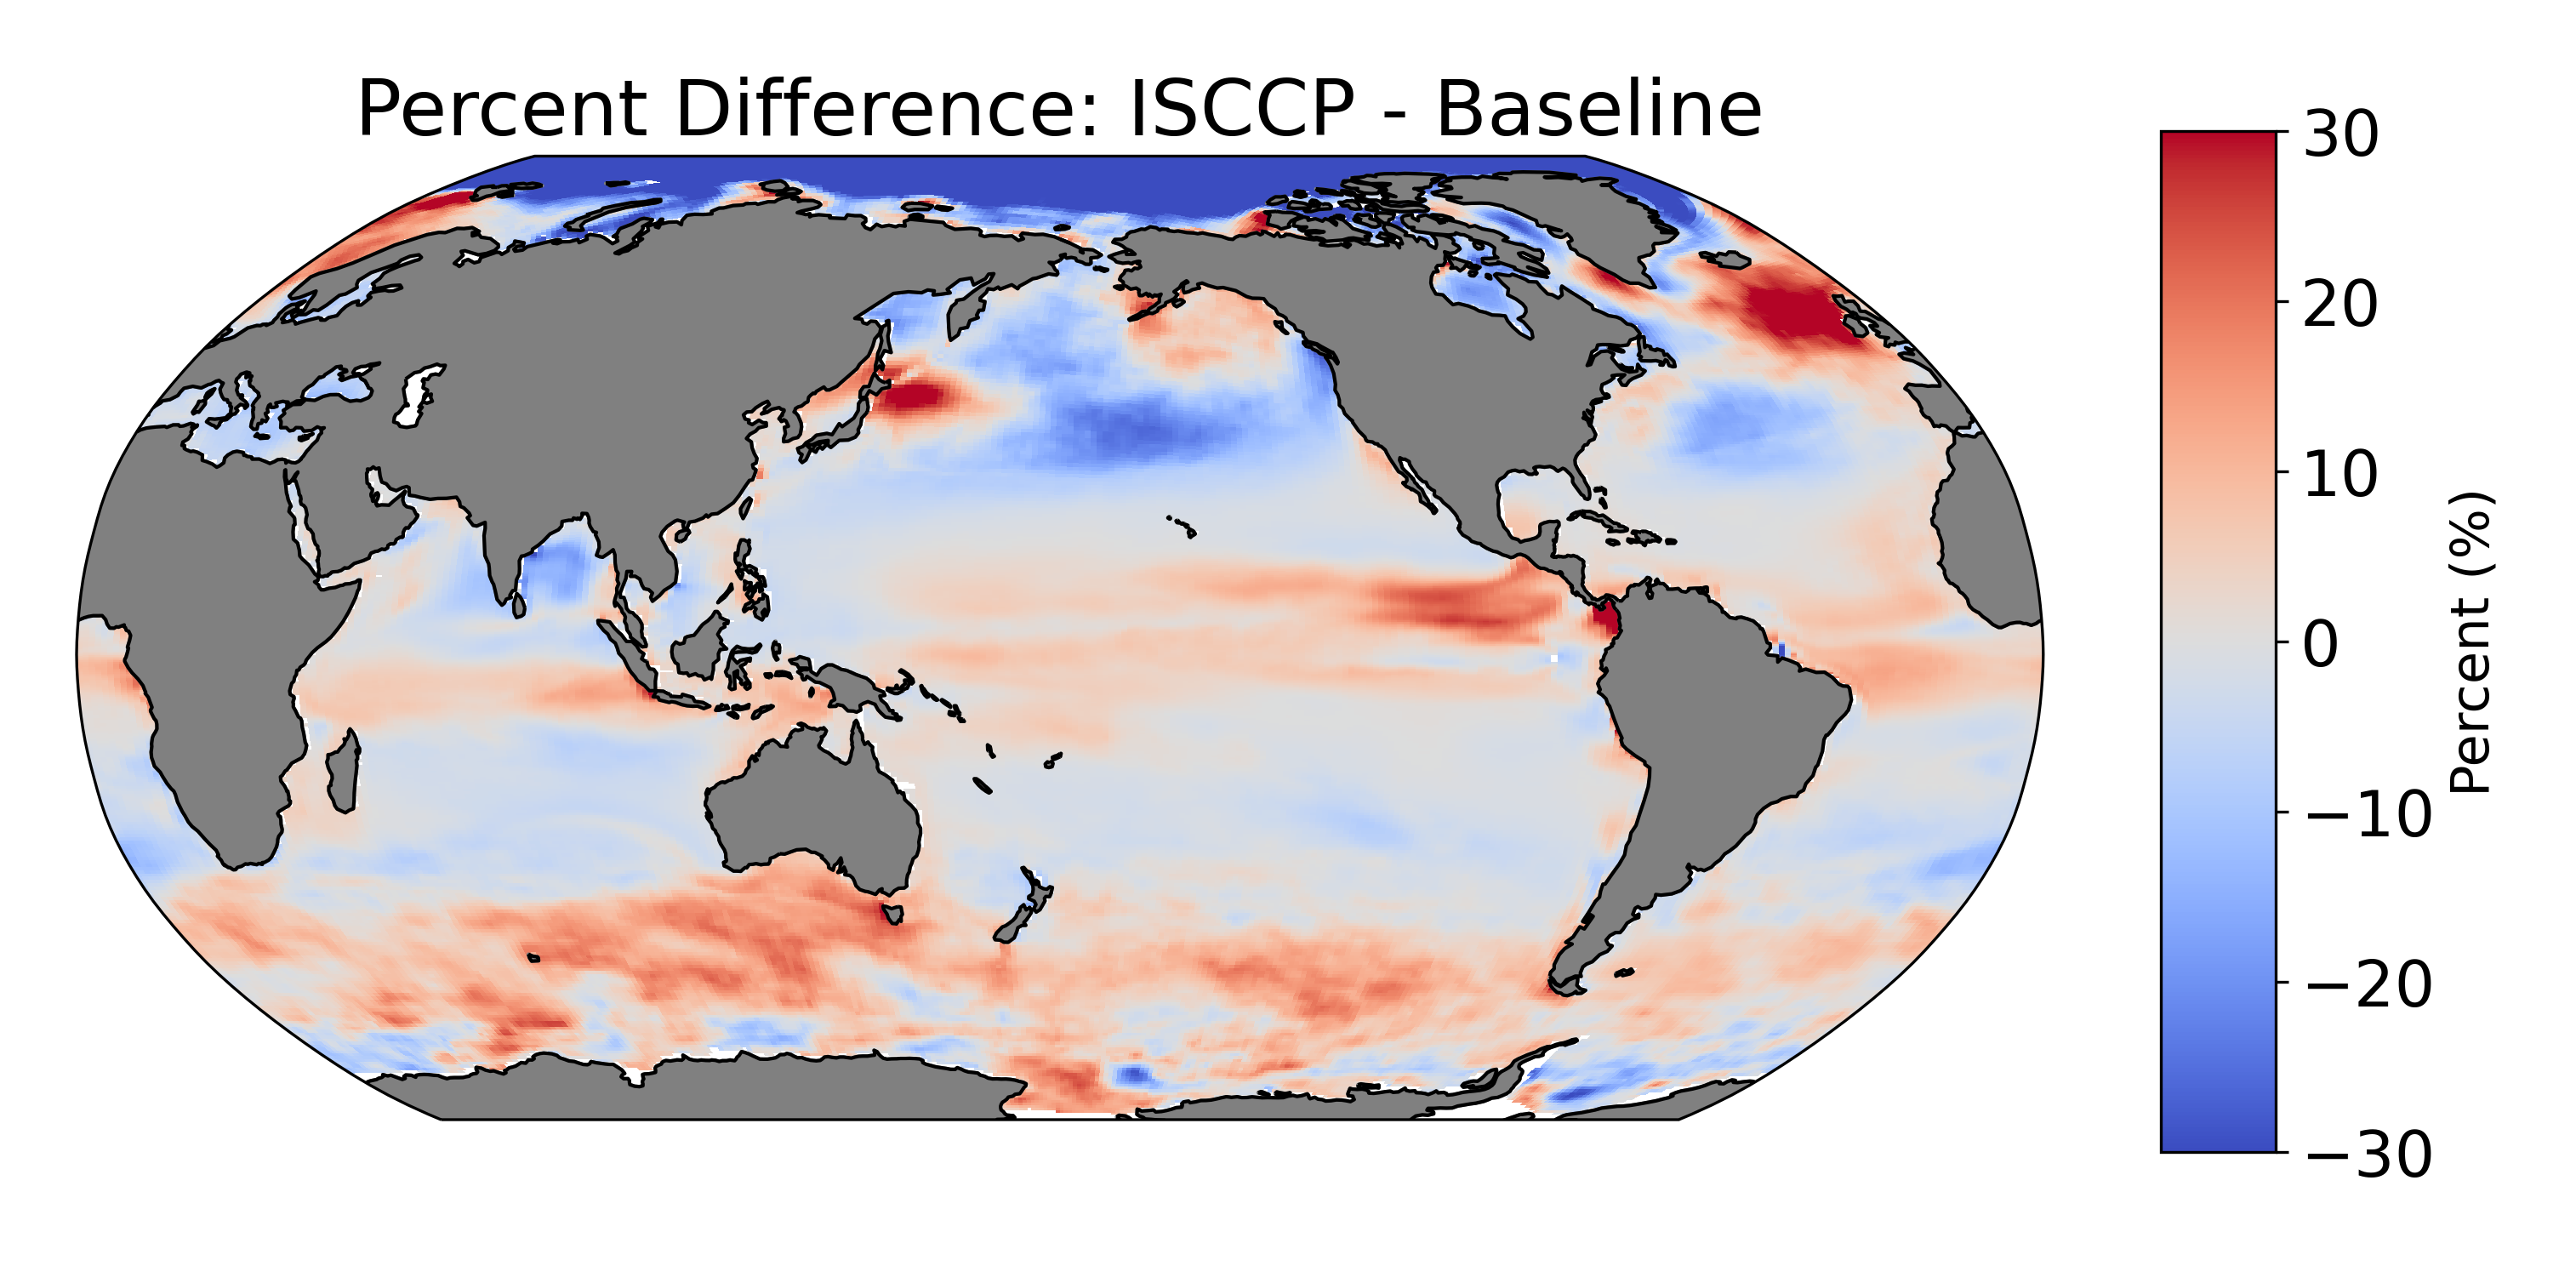

In [1]:
from IPython.display import Image
Image(filename='../plots/climatology_differences/isccp_baseline_per_diff.png') 

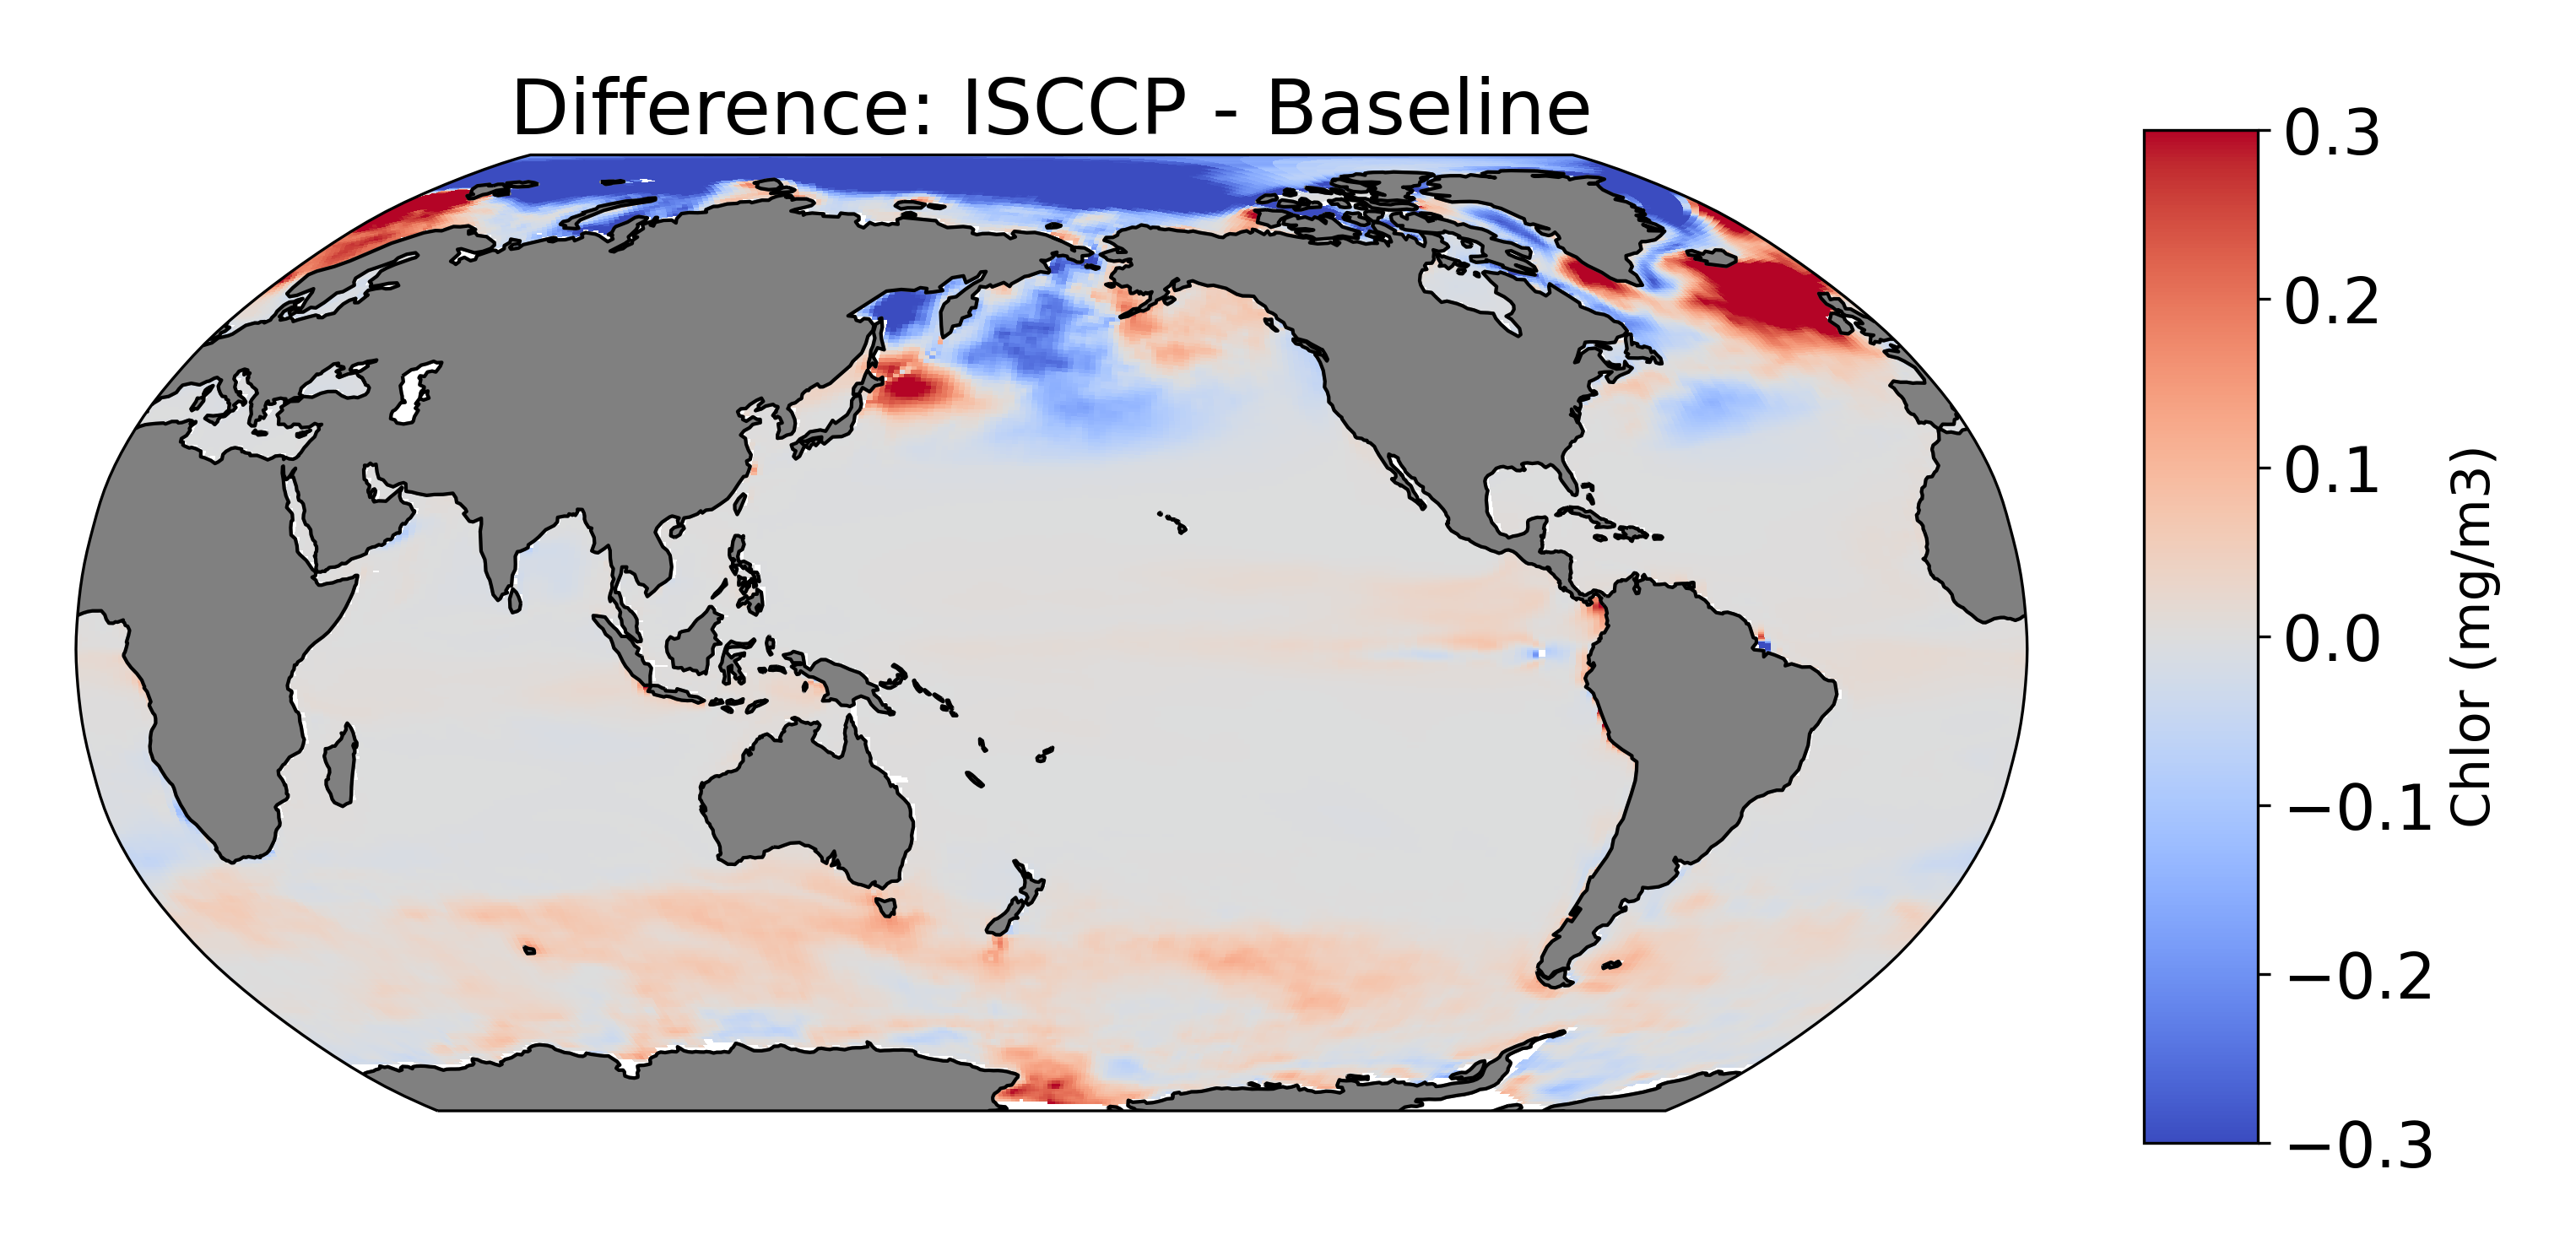

In [2]:
Image(filename='../plots/climatology_differences/isccp_baseline_diff.png') 

**Can the differences between ISCCP chlorophyll and baseline be explained by the seasonal phasing of chlorophyll and clouds?**

1. Calculate daily seasonal cycle in baseline chlor and total chlor for each grid cell
2. Calculate daily seasonal cycle in clouds for each grid cell
3. Calculate correlation between clouds timeseries and chlor timeseries

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [4]:
from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

In [5]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [6]:
cluster = PBSCluster(
    cores=1,
    memory='25GB', #25
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='02:00:00',
    interface='ib0')

client = Client(cluster)
cluster.scale(10) # use when running climatology calculations
client

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42342 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/42342/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/42342/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:38810,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/42342/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Import Data

In [7]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [8]:
%%time

base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'
data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':365},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
data

CPU times: user 1 s, sys: 334 ms, total: 1.34 s
Wall time: 39.6 s


<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>

In [9]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/atm/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.cam.h1.'


cloud_data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks={'time': 365}, 
                              data_vars='minimal', compat='override', 
                              coords='minimal')

cloud_data = cloud_data.sel(time=slice('0020-01-01','0049-12-31'))

In [10]:
# Take the monthly means
baseline_monthly = ((data.totChl_sat_nocld.groupby('time.month').sum(dim='time'))/(data.totChl_sat_nocld_wgt.groupby('time.month').sum(dim='time'))).compute()
baseline_monthly = np.log(baseline_monthly)
isccp_chlor_monthly = ((data.totChl_isccp.groupby('time.month').sum(dim='time'))/(data.totChl_isccp_wgt.groupby('time.month').sum(dim='time'))).compute()
isccp_chlor_monthly = np.log(isccp_chlor_monthly)
clouds_isccp_monthly = ((data.cloudfrac_isccp.groupby('time.month').sum(dim='time'))/(data.cloudfrac_wgt.groupby('time.month').sum(dim='time'))).compute()

# Functions

In [11]:
def calc_linear_regression(x, y):
    x = x[~np.isnan(x)].reshape((-1, 1))
    y = y[~np.isnan(y)]
    if y.shape[0] < 6:
        return np.nan
    else: 
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        #slope = model.coef_
        return r_sq # slope
    
def calc_pearson_corr(x, y):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if y.shape[0] < 2:
        return np.nan
    else:
        corr, p_val = stats.pearsonr(x, y)
        return corr

def calc_spearman_corr(x, y):
    corr, p_val = stats.spearmanr(x[~np.isnan(x)], y[~np.isnan(y)])
    return corr

def calc_spearman_corr_pval(x, y):
    corr, p_val = stats.spearmanr(x[~np.isnan(x)], y[~np.isnan(y)])
    return p_val

In [12]:
def plot_seasonal_cycle_point(lon, lat, var = ['SST','SSS', 'baseline', 'clouds']):
    
    plt.pcolormesh(correlation_doy, cmap='coolwarm_r')
    plt.scatter(lon, lat, color='black', marker='o')
    plt.show()
    
    phys_oc_point = phys_oc_data_monthly.isel(nlon = lon, nlat = lat)
    ecosys_point = ecosys_data_monthly.isel(nlon = lon, nlat = lat)
    baseline_point = baseline_monthly.isel(nlon = lon, nlat = lat)
    clouds_point = clouds_isccp_monthly.isel(nlon = lon, nlat = lat)
    
    data = xr.merge([phys_oc_point, ecosys_point, 
              baseline_point.to_dataset(name = 'baseline'), 
              clouds_point.to_dataset(name = 'clouds')])
    
    data_min = data - data.min()

    # divide each element by the range of the dataset
    normalized_data = data_min / (data.max() - data.min())
    
    fig = plt.figure(figsize=(10, 6))
    
    for v in var: 
        normalized_data[v].plot(label = v)
    
    plt.legend()
    plt.show()


# Linear Regression

### Calculate DOY Means

Does the seasonal cycle contribute to differences?

In [13]:
baseline_doy = ((data.totChl_sat_nocld.groupby('time.dayofyear').sum(dim='time'))/(data.totChl_sat_nocld_wgt.groupby('time.dayofyear').sum(dim='time'))).compute()
isccp_doy = ((data.totChl_isccp.groupby('time.dayofyear').sum(dim='time'))/(data.totChl_isccp_wgt.groupby('time.dayofyear').sum(dim='time'))).compute()
clouds_isccp_doy = ((data.cloudfrac_isccp.groupby('time.dayofyear').sum(dim='time'))/(data.cloudfrac_wgt.groupby('time.dayofyear').sum(dim='time'))).compute()

SpearmanrResult(correlation=-0.6830865967627702, pvalue=1.7575396437078177e-51)

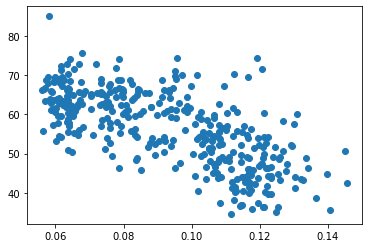

In [14]:
# Test correlation with one point
x = isccp_doy.isel(nlat=220,nlon=175)
y = clouds_isccp_doy.isel(nlat=220,nlon=175)
plt.scatter(x,y)
stats.spearmanr(x[~np.isnan(x)], y[~np.isnan(y)])

In [15]:
# Baseline Chlor
regression_doy = xr.apply_ufunc(
    calc_linear_regression,  # function
    baseline_doy, 
    clouds_isccp_doy,
    input_core_dims=[["dayofyear"], ["dayofyear"]], 
    vectorize=True,
)

correlation_doy = xr.apply_ufunc(
    calc_pearson_corr,  # function
    baseline_doy, 
    clouds_isccp_doy,
    input_core_dims=[["dayofyear"], ["dayofyear"]], 
    vectorize=True,
)

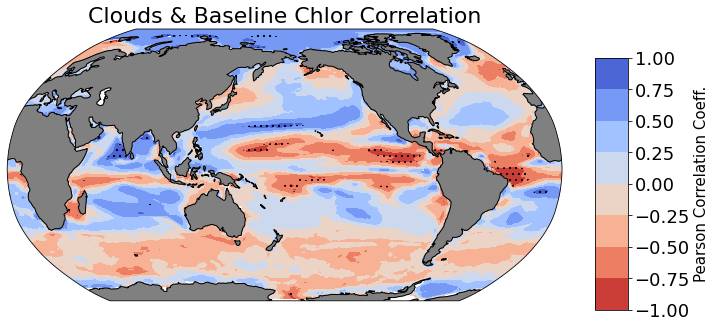

In [16]:
daily_corr_plot = plotting.pop_add_cyclic(correlation_doy.to_dataset(name = 'corr'))
daily_r_sq_plot = plotting.pop_add_cyclic(regression_doy.to_dataset(name = 'r_sq'))

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.contourf(daily_corr_plot.TLONG, daily_corr_plot.TLAT, daily_corr_plot.corr, 
                   transform = ccrs.PlateCarree(), cmap='coolwarm_r') #  norm=TwoSlopeNorm(0), 

levels = [0, 0.5, daily_r_sq_plot.r_sq.max()]
im2 = axs.contourf(daily_r_sq_plot.TLONG, daily_r_sq_plot.TLAT, daily_r_sq_plot.r_sq, 
                   transform = ccrs.PlateCarree(), levels=levels, hatches=["", ".."], alpha = 0)

axs.set_title('Clouds & Baseline Chlor Correlation', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Pearson Correlation Coeff.', size = 15)

Blue: high chlor = high clouds, low chlor = low clouds -- Negative chl bias due to clouds. But in the polar regions, we are not observing the season of low chlor and low clouds because of low sunlight. 

Red: low chlor = high clouds, high chlor = low clouds -- Positive chl bias due to clouds

In [17]:
# Cloudy Chlor
cloudy_regression_doy = xr.apply_ufunc(
    calc_linear_regression,  # function
    isccp_doy, 
    clouds_isccp_doy,
    input_core_dims=[["dayofyear"], ["dayofyear"]], 
    vectorize=True,
)

cloudy_correlation_doy = xr.apply_ufunc(
    calc_pearson_corr,  # function
    isccp_doy, 
    clouds_isccp_doy,
    input_core_dims=[["dayofyear"], ["dayofyear"]], 
    vectorize=True,
)

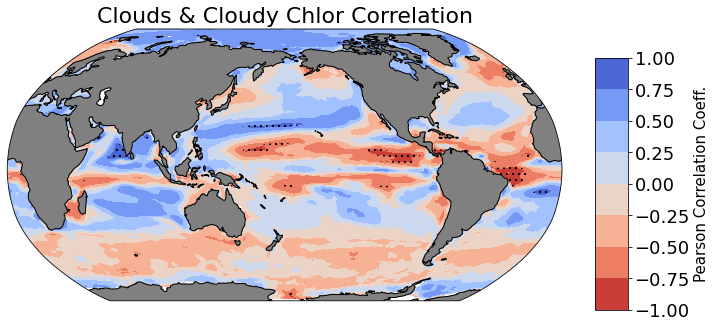

In [18]:
daily_corr_plot = plotting.pop_add_cyclic(cloudy_correlation_doy.to_dataset(name = 'corr'))
daily_r_sq_plot = plotting.pop_add_cyclic(cloudy_regression_doy.to_dataset(name = 'r_sq'))

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.contourf(daily_corr_plot.TLONG, daily_corr_plot.TLAT, daily_corr_plot.corr, 
                   transform = ccrs.PlateCarree(), cmap='coolwarm_r') #  norm=TwoSlopeNorm(0), 

levels = [0, 0.5, daily_r_sq_plot.r_sq.max()]
im2 = axs.contourf(daily_r_sq_plot.TLONG, daily_r_sq_plot.TLAT, daily_r_sq_plot.r_sq, 
                   transform = ccrs.PlateCarree(), levels=levels, hatches=["", ".."], alpha = 0)

axs.set_title('Clouds & Cloudy Chlor Correlation', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Pearson Correlation Coeff.', size = 15)

In [19]:
# Calculate the difference in correlation
corr_diff = cloudy_correlation_doy - correlation_doy

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


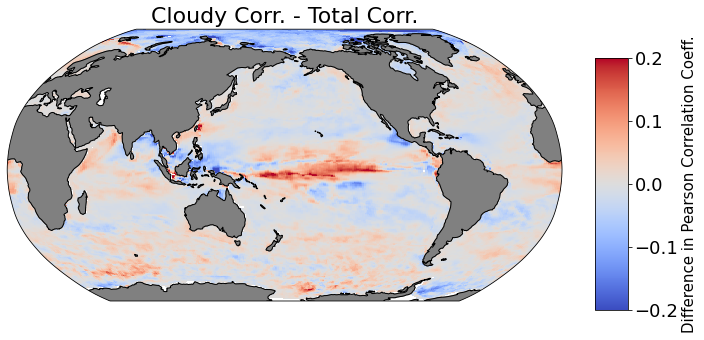

In [20]:
corr_diff_plot = plotting.pop_add_cyclic(corr_diff.to_dataset(name = 'corr_diff'))

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(corr_diff_plot.TLONG, corr_diff_plot.TLAT, corr_diff_plot.corr_diff, 
                   transform = ccrs.PlateCarree(), vmin = -0.2, vmax = 0.2, cmap='coolwarm') #  norm=TwoSlopeNorm(0), 

axs.set_title('Cloudy Corr. - Total Corr.', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Difference in Pearson Correlation Coeff.', size = 15)

### Calculate Annual Means

Is there interannual variability that contributes to differences?

In [21]:
baseline_annual = ((data.totChl_sat_nocld.groupby('time.year').sum(dim='time'))/(data.totChl_sat_nocld_wgt.groupby('time.year').sum(dim='time'))).compute()
clouds_isccp_annual = ((data.cloudfrac_isccp.groupby('time.year').sum(dim='time'))/(data.cloudfrac_wgt.groupby('time.year').sum(dim='time'))).compute()


In [22]:
regression_year = xr.apply_ufunc(
    calc_linear_regression,  # function
    baseline_annual, 
    clouds_isccp_annual,
    input_core_dims=[["year"], ["year"]], 
    vectorize=True,
)

correlation_year = xr.apply_ufunc(
    calc_pearson_corr,  # function
    baseline_annual, 
    clouds_isccp_annual,
    input_core_dims=[["year"], ["year"]], 
    vectorize=True,
)

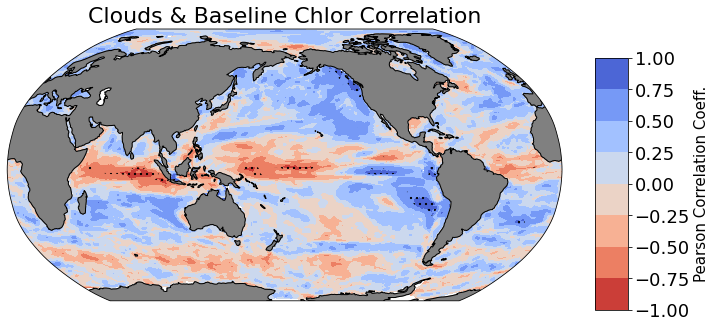

In [23]:
year_corr_plot = plotting.pop_add_cyclic(correlation_year.to_dataset(name = 'corr'))
year_r_sq_plot = plotting.pop_add_cyclic(regression_year.to_dataset(name = 'r_sq'))

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.contourf(year_corr_plot.TLONG, year_corr_plot.TLAT, year_corr_plot.corr, 
                   transform = ccrs.PlateCarree(), cmap='coolwarm_r') #  norm=TwoSlopeNorm(0), 

levels = [0, 0.5, year_r_sq_plot.r_sq.max()]
im2 = axs.contourf(year_r_sq_plot.TLONG, year_r_sq_plot.TLAT, year_r_sq_plot.r_sq, 
                   transform = ccrs.PlateCarree(), levels=levels, hatches=["", ".."], alpha = 0)

axs.set_title('Clouds & Baseline Chlor Correlation', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Pearson Correlation Coeff.', size = 15)

At the equator: high chlorophyll = low clouds and low chlorophyll = high clouds.

In Eastern Pacific: El Nino = low chlor, high clouds & La Nina = high chlor, low clouds

# What drives these relationships?

## Import physical oceanography variables

In [24]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.'

years = range(20,50) 
months = range(1,13)
files = []

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}-01.nc'.format(year, str(month).zfill(2)))

phys_oc_data = xr.open_mfdataset(files, concat_dim="time", parallel = True,
                              data_vars='minimal', compat='override', coords='minimal')

phys_oc_data = phys_oc_data[['SST', 'SSS', 'HMXL_DR_2']]

In [25]:
phys_oc_data_monthly = phys_oc_data.groupby('time.month').mean(dim = 'time').compute()

## Import limitation variables

In [26]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.'

years = range(20,50) 
months = range(1,13)
files = []

var_list = ['sp_N_lim_surf', 'sp_P_lim_surf', 'sp_Fe_lim_surf','sp_light_lim_surf', 
            'diat_N_lim_surf', 'diat_P_lim_surf', 'diat_Fe_lim_surf', 'diat_light_lim_surf', 'diat_SiO3_lim_surf', 
            'diaz_P_lim_surf', 'diaz_Fe_lim_surf', 'diaz_light_lim_surf'] 

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}.nc'.format(year, str(month).zfill(2)))

ecosys_data = xr.open_mfdataset(files, concat_dim="time", parallel = True,
                              data_vars='minimal', compat='override', coords='minimal')

ecosys_data = ecosys_data[var_list]

In [27]:
ecosys_data_monthly = ecosys_data.groupby('time.month').mean(dim = 'time').compute()

## Investigate Seasonal Cycles at Points

In [28]:
from sklearn.preprocessing import MinMaxScaler

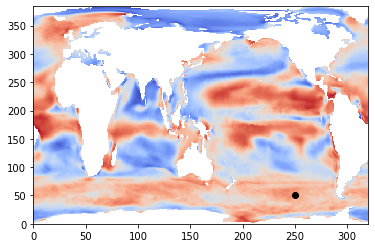

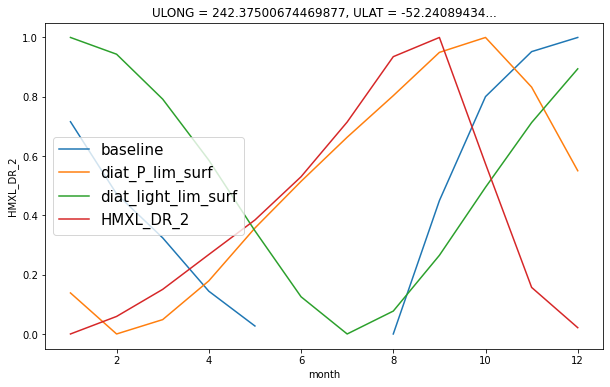

In [29]:
plot_seasonal_cycle_point(250, 50, var = ['baseline', 'diat_P_lim_surf', 
                                           'diat_light_lim_surf', 'HMXL_DR_2'])

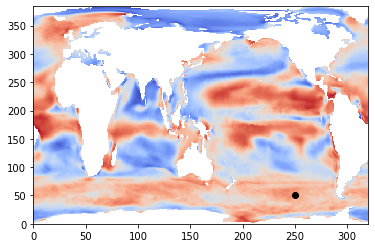

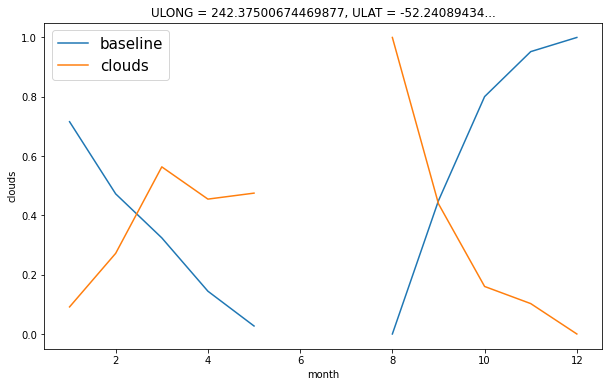

In [30]:
plot_seasonal_cycle_point(250, 50, var = ['baseline', 'clouds'])

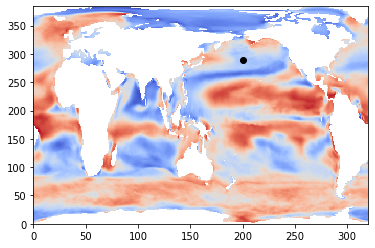

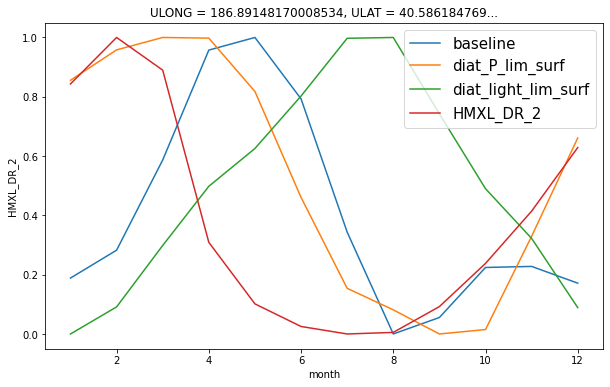

In [31]:
plot_seasonal_cycle_point(200, 290, var = ['baseline', 'diat_P_lim_surf', 
                                           'diat_light_lim_surf', 'HMXL_DR_2'])

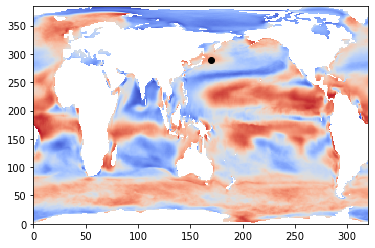

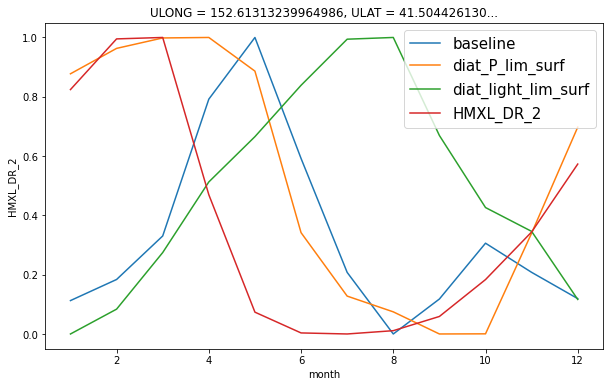

In [32]:
plot_seasonal_cycle_point(170, 290, var = ['baseline', 'diat_P_lim_surf', 
                                           'diat_light_lim_surf', 'HMXL_DR_2'])

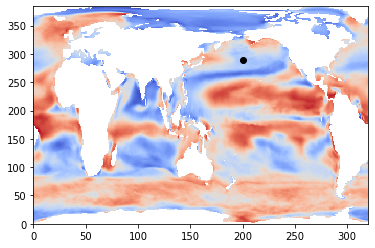

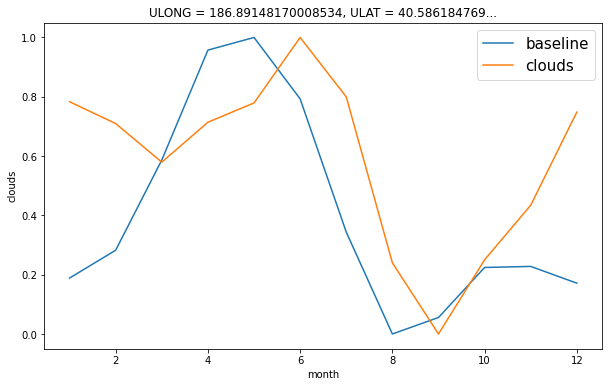

In [33]:
plot_seasonal_cycle_point(200, 290, var = ['baseline', 'clouds'])

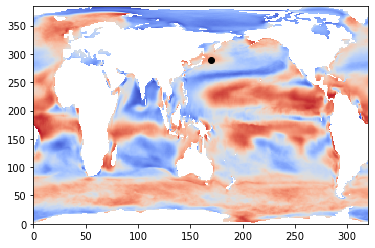

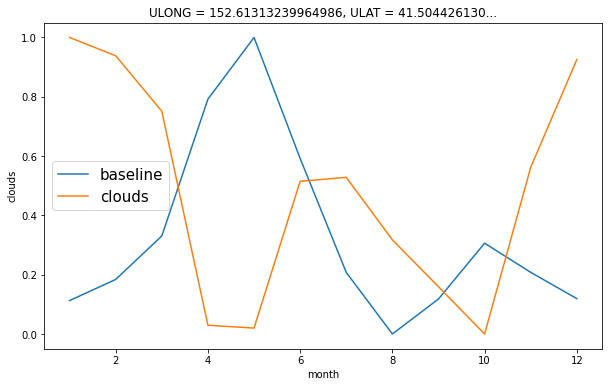

In [34]:
plot_seasonal_cycle_point(170, 290, var = ['baseline', 'clouds'])

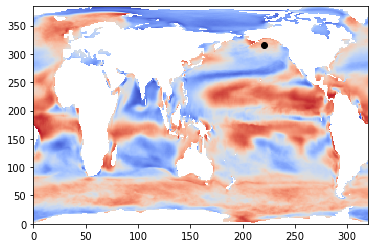

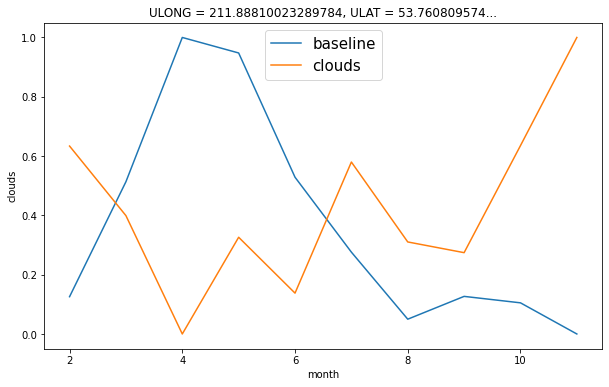

In [35]:
plot_seasonal_cycle_point(220, 315, var = ['baseline', 'clouds'])

# More Correlations

Calculate the magnitude of the seasonal cycle and use as a weight

In [36]:
def calc_range(x):
    chlor_range = np.nanmax(x) - np.nanmin(x)
    return chlor_range

chlor_range = xr.apply_ufunc(
    calc_range,  # first the function
    baseline_monthly, 
    input_core_dims=[["month"]],  # list with one entry per arg
    vectorize=True,  # loop over non-core dims
)

# Scale values between 0 (min) and 1 (max) to use as weights
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

chlor_range_wgt = NormalizeData(chlor_range)

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


### Test with daily data

In [ ]:
daily_corrs = xr.apply_ufunc(
    calc_spearman_corr,  # first the function
    data.totChl_sat_nocld.load(), 
    data.cloudfrac_isccp.load(),
    input_core_dims=[["time"], ["time"]],  # list with one entry per arg
    vectorize=True,  # loop over non-core dims
)

In [ ]:
daily_corr_plot = plotting.pop_add_cyclic(daily_corrs.to_dataset(name = 'corr'))

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(daily_corr_plot.TLONG, daily_corr_plot.TLAT, daily_corr_plot.corr, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), cmap='coolwarm_r')

axs.set_title('Daylight Clouds & Chlor Daily Correlation', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Spearman Correlation Coeff.', size = 15)

### Test daily totChl and total clouds

In [ ]:
pop_grid = data.TLAT
pop_grid = pop_grid.rename({'TLONG':'lon','TLAT':'lat'})

regridder = xe.Regridder(cloud_data.CLDTOT, pop_grid, "nearest_s2d")
clouds_rg = regridder(cloud_data.CLDTOT)

In [ ]:
daily_corrs_tot = xr.apply_ufunc(
    calc_spearman_corr,  # first the function
    data.totChl.load(), 
    clouds_rg.where(~data.totChl.isnull()).load(),
    input_core_dims=[["time"], ["time"]],  # list with one entry per arg
    vectorize=True,  # loop over non-core dims
)

In [ ]:
daily_corr_plot = plotting.pop_add_cyclic(daily_corrs_tot.to_dataset(name = 'corr'))
# daily_corr_pval_plot = plotting.pop_add_cyclic(daily_corrs_tot_pval.to_dataset(name = 'pval'))


fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(daily_corr_plot.TLONG, daily_corr_plot.TLAT, daily_corr_plot.corr, 
                   transform = ccrs.PlateCarree(), vmin = -0.3, vmax = 0.3, cmap='coolwarm_r') #  norm=TwoSlopeNorm(0), 

axs.set_title('Total Clouds & Chlor Daily Correlation', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.7])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Spearman Correlation Coeff.', size = 15)

In [ ]:
cluster.close()
client.close()